<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/wildfires_risk_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install geojson

In [42]:
import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.validation import make_valid
import geojson
import zipfile
import ee
import geemap
from shapely.geometry import mapping

In [4]:
my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)

In [34]:

# if the input is a shapefile
country = 'Ivory Coast'
project_area_name = 'Calao' #region/country/project name
input_shp = "calao_for_eligibility.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')

In [45]:
# Define the date range
start_date = '2000-01-01'
end_date = '2023-12-31'

# Load the MODIS Burned Area dataset
fire_dataset = ee.ImageCollection("MODIS/006/MCD64A1").select('BurnDate').filterDate(start_date, end_date)

# Function to compute burned area for a given year
def calculate_burned_area(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    # Filter images for the given year
    yearly_images = fire_dataset.filterDate(start, end)

    # Check if there are images in the collection
    count = yearly_images.size()
    burned_area = ee.Algorithms.If(
        count.gt(0),  # If images exist, calculate burned area
        yearly_images.map(lambda img: img.gt(0).selfMask()).sum()
        .multiply(0.25)  # Convert pixels to hectares
        .reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),  # Global extent
            scale=500,
            maxPixels=1e13
        ).getNumber('BurnDate'),
        0  # If no images exist, return 0
    )

    return ee.Feature(None, {'year': year, 'area_burned(ha)': burned_area})

# Generate a list of years and compute burned area
years = list(range(2000, 2024))
features = ee.FeatureCollection([calculate_burned_area(y) for y in years])

# Convert to Pandas DataFrame
burned_area_dict = features.aggregate_array('year').getInfo(), features.aggregate_array('area_burned(ha)').getInfo()
df = pd.DataFrame({'year': burned_area_dict[0], 'area_burned(ha)': burned_area_dict[1]})

# Ensure missing values are set to 0
df['area_burned(ha)'] = df['area_burned(ha)'].fillna(0)

# Display the result
print(df)


KeyboardInterrupt: 

In [ ]:
def get_shapefile_centroid(gdf):
    """Ensure CRS is geographic and return the centroid coordinates."""
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    centroid = gdf.unary_union.centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    """ Returns the best UTM zone EPSG code based on latitude """
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

In [22]:
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)  # Replace with actual latitude
print(best_epsg)

EPSG:32630


<ipython-input-21-8622922bd85d>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid


In [23]:
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()
print(f"Total area in hectares: {total_area_ha}")

Total area in hectares: 32027.857300088293


In [25]:
# Add a new column to the DataFrame that represents the percentage of burned area
df['percentage_burned'] = (df['area_burned(ha)'] / total_area_ha) * 100

# Display the updated DataFrame
print(df)

    year  area_burned(ha)  percentage_burned
0   2000        10.500000           0.032784
1   2001       289.405882           0.903607
2   2002      1074.750000           3.355673
3   2003       520.437255           1.624952
4   2004       415.089216           1.296026
5   2005       948.156863           2.960413
6   2006      1312.469608           4.097900
7   2007       613.000000           1.913959
8   2008       462.668627           1.444582
9   2009       251.641176           0.785695
10  2010       295.639216           0.923069
11  2011       728.471569           2.274494
12  2012       627.642157           1.959676
13  2013      1358.274510           4.240916
14  2014       304.250000           0.949954
15  2015       859.000000           2.682040
16  2016       764.339216           2.386483
17  2017      1859.883333           5.807080
18  2018      1254.437255           3.916707
19  2019       302.017647           0.942984
20  2020      3919.477451          12.237714
21  2021  

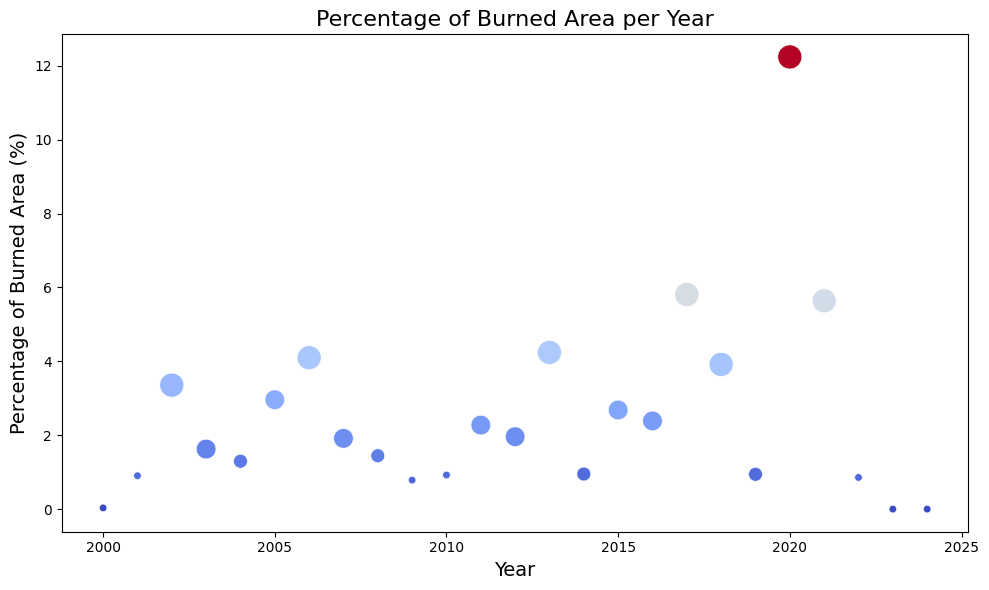

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' contains the 'year', 'percentage_burned', and 'area_burned(ha)' columns
# Categorize the point sizes based on the area burned
def size_category(area):
    if area < 300:
        return 30  # Small
    elif 300 <= area < 500:
        return 100  # Medium
    elif 500 <= area < 1000:
        return 200  # Medium-large
    else:
        return 300  # Large

# Apply the size category function to the 'area_burned(ha)' column
df['point_size'] = df['area_burned(ha)'].apply(size_category)

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='percentage_burned', size='point_size', sizes=(30, 300), hue='percentage_burned', palette='coolwarm', legend=False)

# Set the labels and title
plt.title('Percentage of Burned Area per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Burned Area (%)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()
